In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from tqdm import tqdm
# import time
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#
# from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.naive_bayes import MultinomialNB
# import xgboost as xgb
# from sklearn import preprocessing, model_selection, pipeline
# from sklearn.metrics import f1_score, roc_auc_score
#
# from keras.models import Sequential
# from keras.layers import LSTM, GRU, Embedding, BatchNormalization
# from keras.layers.core import Dense, Activation, Dropout
# from keras.utils import np_utils
# from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
# from keras.preprocessing import sequence, text
# from keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('../data/fake_job_postings.csv', engine = 'python')
df = df.drop(['job_id'], axis = 1)
# 대부분 missing 인 col 제거
df = df.drop(['department','salary_range'], axis = 1)
df.head()

In [ ]:
print(df.shape)
df.isnull().sum()

In [ ]:
df[df['fraudulent'] == 0].isnull().sum() / df.isnull().sum()

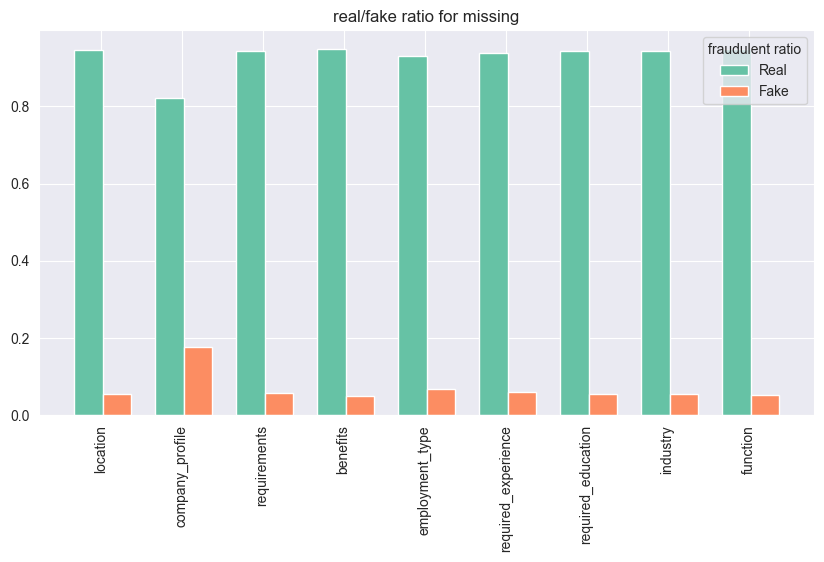

In [41]:
# 결측치의 real/fake 비율
missing_real = df[df['fraudulent'] == 0].isnull().sum() / df.isnull().sum()
missing_fake = df[df['fraudulent'] == 1].isnull().sum() / df.isnull().sum()

# 결측치 0,1개 인 col 제거
missing_real = missing_real.drop(['title','description','telecommuting','has_company_logo','has_questions','fraudulent'])
missing_fake = missing_fake.drop(['title','description','telecommuting','has_company_logo','has_questions','fraudulent'])

#결측치의 비율 plot
fig, ax = plt.subplots(1,1, figsize=(10,5))
index = np.arange(missing_real.shape[0])
bar_width = 0.35
sns.set_palette('Set2')
plt.bar(index, missing_real, bar_width, label = 'Real')
plt.bar(index + bar_width, missing_fake, bar_width, label = 'Fake')
plt.legend(title = 'fraudulent ratio')
plt.title('real/fake ratio for missing')
plt.xticks(index+0.15, missing_real.index)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.show()


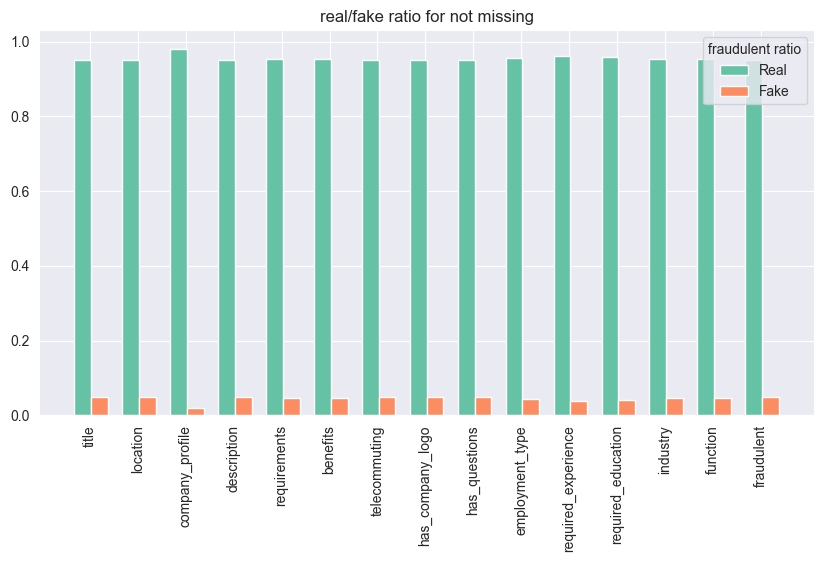

In [42]:
# not 결측치 real/fake 비율
hasvalue_real = df[df['fraudulent'] == 0].notnull().sum() / df.notnull().sum()
hasvalue_fake = df[df['fraudulent'] == 1].notnull().sum() / df.notnull().sum()

# not 결측치의 비율 plot
fig, ax = plt.subplots(1,1, figsize=(10,5))
index = np.arange(hasvalue_real.shape[0])
bar_width = 0.35
sns.set_palette('Set2')
plt.bar(index, hasvalue_real, bar_width, label = 'Real')
plt.bar(index + bar_width, hasvalue_fake, bar_width, label = 'Fake')
plt.legend(title = 'fraudulent ratio')
plt.title('real/fake ratio for not missing')
plt.xticks(index+0.15, hasvalue_real.index)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.show()

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   company_profile      14572 non-null  object
 3   description          17879 non-null  object
 4   requirements         15184 non-null  object
 5   benefits             10668 non-null  object
 6   telecommuting        17880 non-null  int64 
 7   has_company_logo     17880 non-null  int64 
 8   has_questions        17880 non-null  int64 
 9   employment_type      14409 non-null  object
 10  required_experience  10830 non-null  object
 11  required_education   9775 non-null   object
 12  industry             12977 non-null  object
 13  function             11425 non-null  object
 14  fraudulent           17880 non-null  int64 
dtypes: int64(4), object(11)
memory usage: 2.0+ MB


In [48]:
# data col 분리
text_col = ['title','company_profile','description','requirements','benefits']
cat_col = ['location', 'telecommuting','has_company_logo','has_questions','employment_type','required_experience','required_education','industry','function']

text_df = df.loc[:, text_col + ['fraudulent']]
text_df = text_df.fillna(' ')

cat_df = df.loc[:, cat_col + ['fraudulent']]
cat_df = cat_df.fillna('None')

text_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [49]:
cat_df.head()

,location,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,"US, NY, New York",0,1,0,Other,Internship,None,None,Marketing,0
1,"NZ, , Auckland",0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,"US, IA, Wever",0,1,0,None,None,None,None,None,0
3,"US, DC, Washington",0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,"US, FL, Fort Worth",0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [50]:
# column 각각의  범주 별 real/fake 비율 (cat_col에 적용할 예정)
def cat_label_plot(col, data, r1=0, r2=0):
  plt.figure(figsize = (5,5))
  ax = plt.subplot(1,1,1)
  sns.set_palette('Set2')
  sns.countplot(x = col, data = data, hue = 'fraudulent')
  plt.title('{} distribution by fraudulent'.format(col))
  plt.setp(ax.xaxis.get_majorticklabels(), rotation = r1)
  size = []
  for p in ax.patches:
    h = p.get_height()
    size.append(h)
    w = p.get_width()
    x = p.get_x()
    ax.text(x + w/2, h + 5, '{:1.2f}%'.format(h/len(data)*100), ha = 'center', rotation = r2)
  plt.show()

In [51]:
# column 각각의 글자수 별  real/fake 비율 (text_col에 적용할 예정)
def text_char_plot(col, data, nbins):
  fig = plt.figure(figsize = (5,5))
  ax = plt.subplot(1,1,1)
  len0 = data[data['fraudulent'] == 0][col].str.len()
  len1 = data[data['fraudulent'] == 1][col].str.len()
  max_n = max(max(len0), max(len1))
  bin_width = max_n / nbins
  bins = np.arange(0, max_n + bin_width, bin_width)
  sns.set_palette('Set2')
  ax.hist(len0, bins = bins, density = True, histtype = 'stepfilled', alpha = 0.5, label = 'True')
  ax.hist(len1, bins = bins, density = True, histtype = 'stepfilled', alpha = 0.5, label = 'Fake')
  plt.legend()
  plt.title('characters comparison in {}'.format(col))
  plt.show()

In [54]:
# column 각각의 단어수 별  real/fake 비율 (text_col에 적용할 예정)
def text_word_plot(col, data, nbins):
  fig = plt.figure(figsize = (5,5))
  ax = plt.subplot(1,1,1)
  len0 = data[data['fraudulent'] == 0][col].str.split().map(lambda x : len(x))
  len1 = data[data['fraudulent'] == 1][col].str.split().map(lambda x : len(x))
  max_n = max(max(len0), max(len1))
  bin_width = max_n / nbins
  bins = np.arange(0, max_n + bin_width, bin_width)
  sns.set_palette('Set2')
  ax.hist(len0, bins = bins, density = True, histtype = 'stepfilled', alpha = 0.5, label = 'True')
  ax.hist(len1, bins = bins, density = True, histtype = 'stepfilled', alpha = 0.5, label = 'Fake')
  plt.title('words comparison in {}'.format(col))
  plt.legend()
  plt.show()

In [77]:
# Task 9 null값 빼고 word/character plot 찍기
cat_df_dropna = df.loc[:, cat_col + ['fraudulent']].dropna()
text_df_dropna = df.loc[:, text_col + ['fraudulent']].dropna()

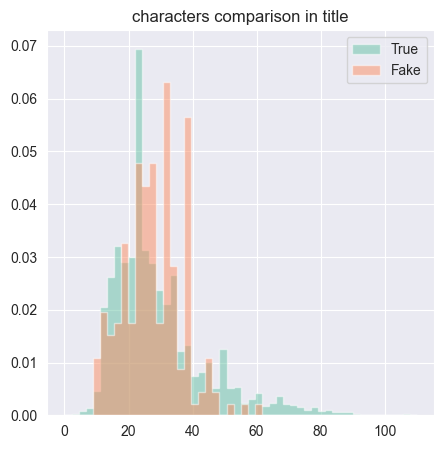

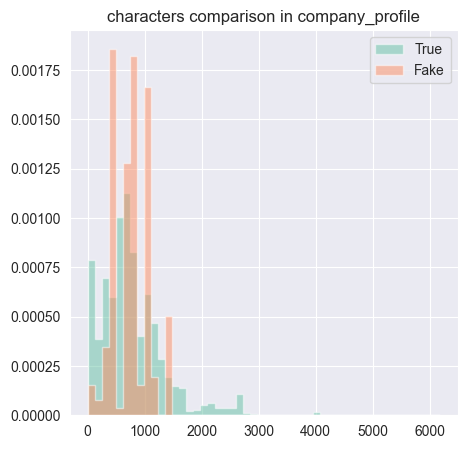

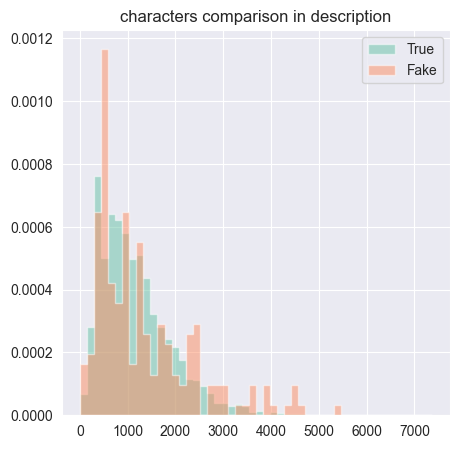

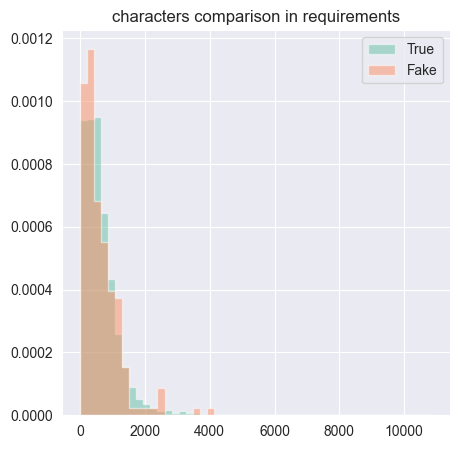

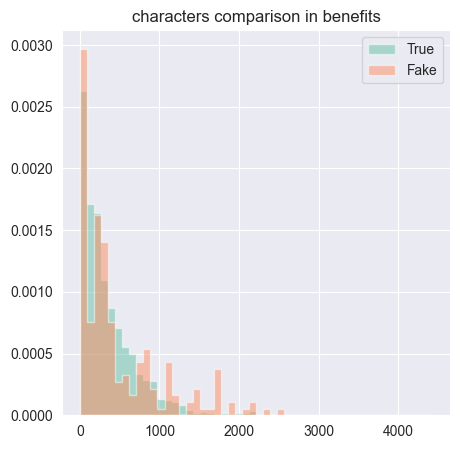

In [56]:
for col in text_col:
  text_char_plot(col, text_df_dropna, 50)

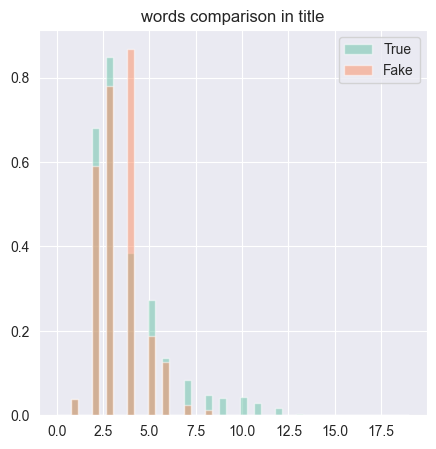

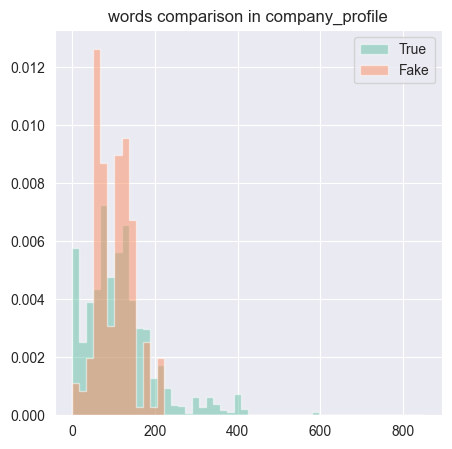

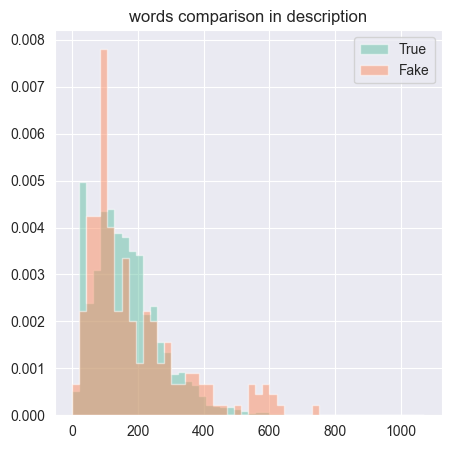

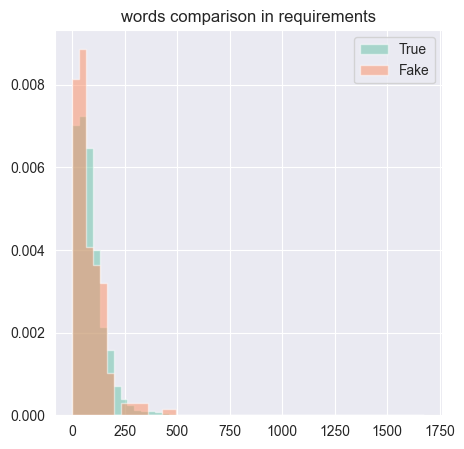

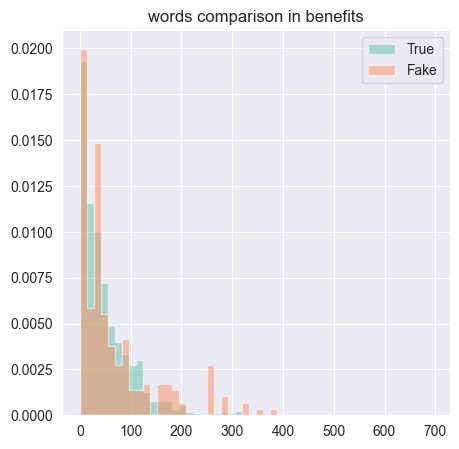

In [57]:
for col in text_col:
  text_word_plot(col, text_df_dropna, 50)

In [79]:
# Task 10 단어 수 많은 text_df 특징 ( col별 cleansing 전)

# title - 7 단어 넘으면 대부분 Real
# company_profile - 180 단어 넘으면 대부분 Real
# description - 500 단어 넘으면 대부분 Fake
# requirements - 특징 x
# benefits - 120단어 넘으면 대부분 Fake

# Task 10 단어 수 많은 text_df 특징 ( col별 cleansing 후)
# title - 특징 x
# company_profile - 180 단어 넘으면 대부분 Real
# description - 특징 x
# requirements - 특징 x
# benefits - 특징 x

#cleansing 방법에 따라 너무 쉽게 달라짐. 최종 cleanisng 끝난 후 새롭게 분석해야 할 것 같음.

In [ ]:
# Task 11 re 패키지 적용(cleansing) 하고 전처리 과정 다시 진행.

In [69]:
# data cleansing - 소문자화, []제거, 링크제거, 숫자 포함 제거
def clean_text(text):
  text = text.lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text

In [68]:
# null은 아닌데 공백인 경우가 존재 - 길이 1 -> null 처리 유무 결정 필요
len(text_df['company_profile'][5])

1

In [74]:
# text 데이터에 대해 각 col별 cleansing 진행 후 전처리 과정 다시 진행
text_df_cleansing = text_df.copy()
text_df_cleansing.iloc[:,:-1] = text_df_cleansing.iloc[:,:-1].applymap(lambda x: clean_text(x))

text_df_text_df_cleansing_dropna = text_df_cleansing.dropna()

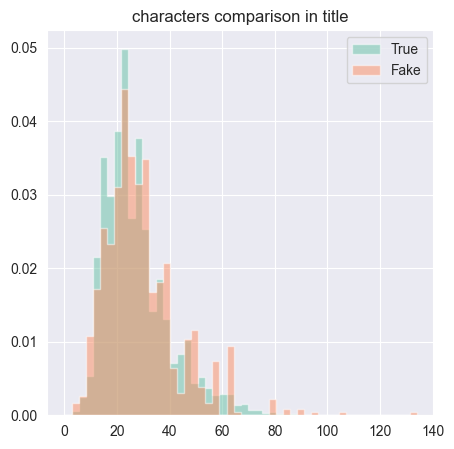

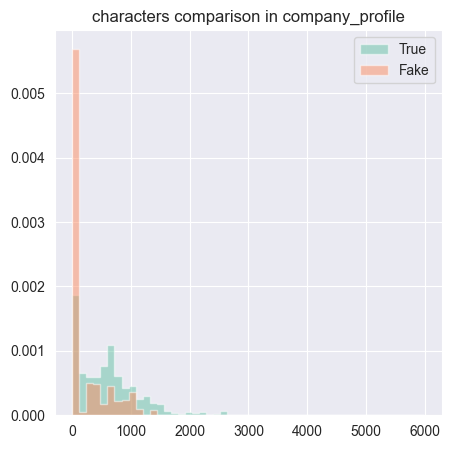

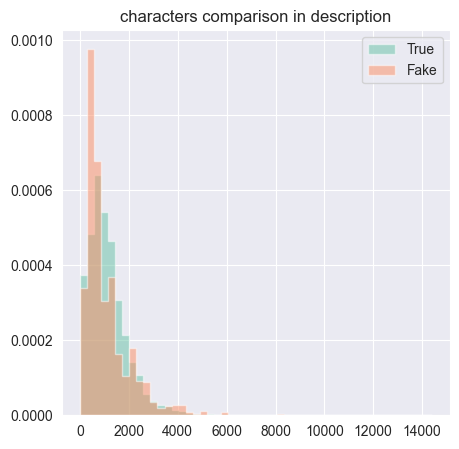

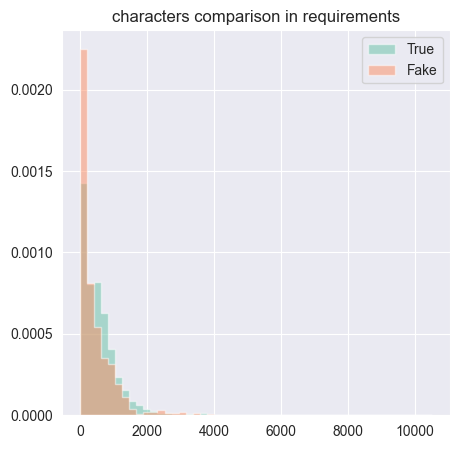

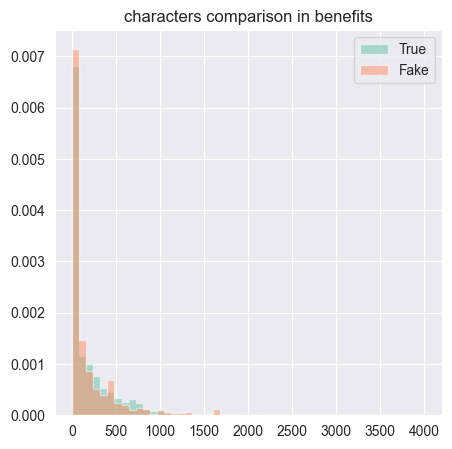

In [75]:
for col in text_col:
  text_char_plot(col, text_df_text_df_cleansing_dropna, 50)

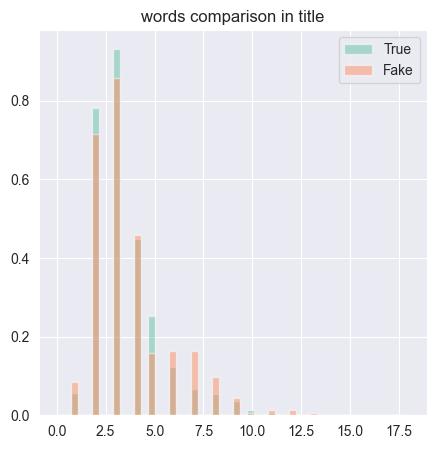

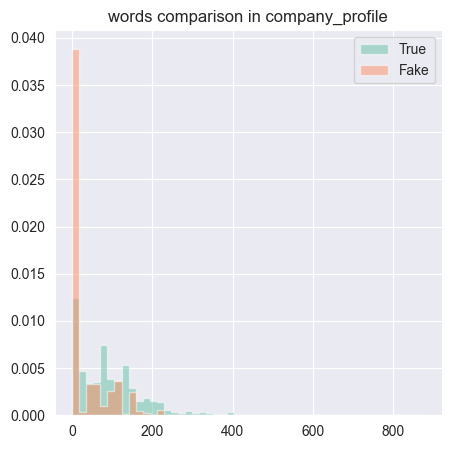

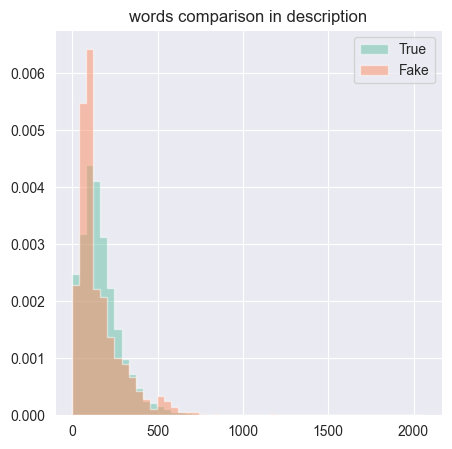

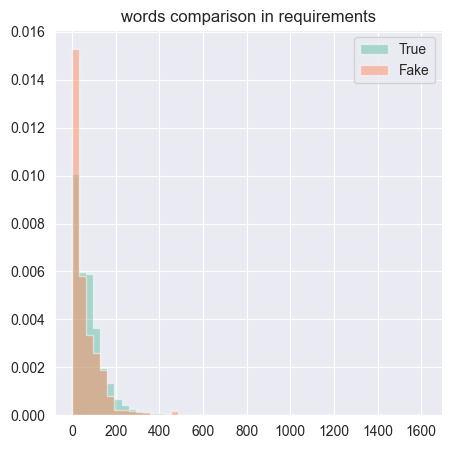

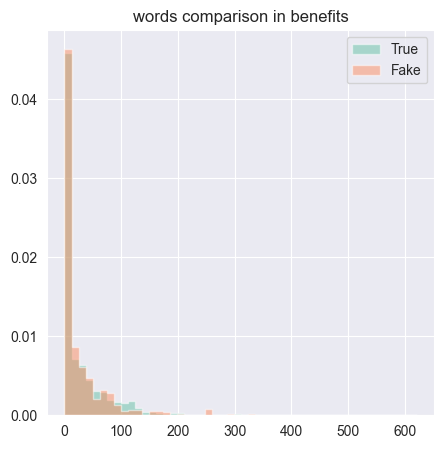

In [76]:
for col in text_col:
  text_word_plot(col, text_df_text_df_cleansing_dropna, 50)